# <div align="center"><b>Weighted gene correlation network analysis (WGCNA)</b></div>

In [1]:
import pandas as pd
import PyWGCNA

In [13]:
path_counts = "/tscc/nfs/home/aklie/scratch/feature_counts/hangauer.results.counts"
path_out = '/tscc/nfs/home/aklie/scratch/wgcna/'

In [3]:
%%bash
mkdir -p path_out

# Load data

In [4]:
# Load counts_df
counts_df = pd.read_csv(path_counts, comment="#", sep="\t", index_col=0)
gene_info = counts_df.iloc[:, 0:5]
counts_df = counts_df.iloc[:, 5:]
counts_df = counts_df.rename(
    columns=
    {
        counts_df.columns[0]:"Parental1",
        counts_df.columns[1]:"Parental2",
        counts_df.columns[2]:"Persister1",
        counts_df.columns[3]:"Persister2",
        counts_df.columns[4]:"Persister3"
    }
)
counts_df.head()

,Parental1,Parental2,Persister1,Persister2,Persister3
Geneid,,,,,
ENSG00000223972.4,0,0,0,0,0
ENSG00000227232.4,16,19,44,38,61
ENSG00000243485.2,0,0,0,0,0
ENSG00000237613.2,0,0,0,0,0
ENSG00000268020.2,0,0,0,0,0


In [23]:
# Create metadata with condition
metadata = pd.DataFrame(index=counts_df.columns)
metadata["condition"] = metadata.index.str[:-1]
metadata

,condition
Parental1,Parental
Parental2,Parental
Persister1,Persister
Persister2,Persister
Persister3,Persister


# TPM normalization

In [6]:
def normalize_tpm(counts_matrix, gene_lengths):
    """
    Normalize an RNA-seq counts matrix using Transcripts Per Kilobase Million (TPM).
    
    Transcripts Per Kilobase Million (TPM) is an improvement over RPKM/FPKM. 
    TPM first normalizes for gene length, then for sequencing depth, making the sum 
    of all TPMs in each sample identical. This allows for a more accurate comparison 
    of gene expression between samples.
    
    Pros:
    - More accurate than RPKM/FPKM for comparing gene expression levels between samples.
    - Accounts for the total sum of normalized expression levels, allowing for a more balanced comparison.
    
    Cons:
    - Can be affected by highly expressed genes and depends on accurate estimates of gene lengths and accurate read mapping.
    - Cannot be used for differential expression analysis.
    
    Parameters:
    counts_matrix (pd.DataFrame): A pandas DataFrame containing raw read counts 
                                  with rows as genes and columns as samples.
    gene_lengths (pd.Series): A pandas Series containing the lengths of genes in kilobases.
                              The index should match the row index of the counts_matrix.
    
    Returns:
    pd.DataFrame: A pandas DataFrame with TPM-normalized expression values.
    
    Raises:
    ValueError: If the input counts_matrix is not a pandas DataFrame or if gene_lengths is not a pandas Series.
    """
    
    if not isinstance(counts_matrix, pd.DataFrame):
        raise ValueError("counts_matrix must be a pandas DataFrame.")
    
    if not isinstance(gene_lengths, pd.Series):
        raise ValueError("gene_lengths must be a pandas Series.")
    
    if not all(counts_matrix.index == gene_lengths.index):
        raise ValueError("The index of counts_matrix and gene_lengths must match.")
    
    # Normalize by gene length in kilobases
    length_normalized = counts_matrix.div(gene_lengths, axis=0)
    
    # Calculate per-sample scaling factors (total sum of length-normalized counts)
    scaling_factors = length_normalized.sum(axis=0)
    
    # Normalize by scaling factors and multiply by 1e6 to get TPM
    tpm_matrix = length_normalized.div(scaling_factors, axis=1) * 1e6
    
    return tpm_matrix

In [7]:
# Get gene lengths
gene_lengths = gene_info["Length"]
gene_lengths.head()

Geneid
ENSG00000223972.4    1756
ENSG00000227232.4    2073
ENSG00000243485.2    1021
ENSG00000237613.2    1219
ENSG00000268020.2     947
Name: Length, dtype: int64

In [8]:
# Normalize counts using TPM
tpm = normalize_tpm(counts_df, gene_lengths)
tpm.head()

,Parental1,Parental2,Persister1,Persister2,Persister3
Geneid,,,,,
ENSG00000223972.4,0.000000,0.000000,0.000000,0.00000,0.000000
ENSG00000227232.4,0.528894,0.635865,1.587914,1.26325,2.200101
ENSG00000243485.2,0.000000,0.000000,0.000000,0.00000,0.000000
ENSG00000237613.2,0.000000,0.000000,0.000000,0.00000,0.000000
ENSG00000268020.2,0.000000,0.000000,0.000000,0.00000,0.000000


In [9]:
tpm = tpm.T

In [10]:
tpm

Geneid,ENSG00000223972.4,ENSG00000227232.4,ENSG00000243485.2,ENSG00000237613.2,ENSG00000268020.2,ENSG00000240361.1,ENSG00000186092.4,ENSG00000238009.2,ENSG00000239945.1,ENSG00000233750.3,...,ENSG00000198886.2,ENSG00000210176.1,ENSG00000210184.1,ENSG00000210191.1,ENSG00000198786.2,ENSG00000198695.2,ENSG00000210194.1,ENSG00000198727.2,ENSG00000210195.2,ENSG00000210196.2
Parental1,0.0,0.528894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,27230.961236,231.395435,295.005194,588.734442,8611.097689,8365.380533,0.0,20398.358026,478.635544,1350.342208
Parental2,0.0,0.635865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,26680.400682,257.395909,330.419047,604.843568,8514.784993,7906.512882,0.0,19917.851964,500.349861,1272.237835
Persister1,0.0,1.587914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,32011.676245,191.910094,284.033555,632.217545,17319.072790,18448.170174,0.0,31012.727039,352.525142,2344.488891
Persister2,0.0,1.263250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036156,...,33175.540566,198.750778,225.429189,509.572293,19342.963580,19586.685139,0.0,30356.102592,315.331865,2147.468962
Persister3,0.0,2.200101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.137296,...,32819.943931,226.469269,294.000492,628.677715,17183.661687,18614.083543,0.0,29724.189174,302.467982,2172.651706


In [14]:
adata = PyWGCNA.WGCNA(
    name="hangauer",
    species="homo sapiens",
    geneExp=tpm,
    sampleInfo=metadata,
    outputPath=path_out,
    save=True
)
adata.geneExpr.to_df().head(5)

Saving data to be True, checking requirements ...
Figure directory does not exist!
Creating figure directory!


Geneid,ENSG00000223972.4,ENSG00000227232.4,ENSG00000243485.2,ENSG00000237613.2,ENSG00000268020.2,ENSG00000240361.1,ENSG00000186092.4,ENSG00000238009.2,ENSG00000239945.1,ENSG00000233750.3,...,ENSG00000198886.2,ENSG00000210176.1,ENSG00000210184.1,ENSG00000210191.1,ENSG00000198786.2,ENSG00000198695.2,ENSG00000210194.1,ENSG00000198727.2,ENSG00000210195.2,ENSG00000210196.2
Parental1,0.0,0.528894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,27230.961236,231.395435,295.005194,588.734442,8611.097689,8365.380533,0.0,20398.358026,478.635544,1350.342208
Parental2,0.0,0.635865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,26680.400682,257.395909,330.419047,604.843568,8514.784993,7906.512882,0.0,19917.851964,500.349861,1272.237835
Persister1,0.0,1.587914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,32011.676245,191.910094,284.033555,632.217545,17319.072790,18448.170174,0.0,31012.727039,352.525142,2344.488891
Persister2,0.0,1.263250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036156,...,33175.540566,198.750778,225.429189,509.572293,19342.963580,19586.685139,0.0,30356.102592,315.331865,2147.468962
Persister3,0.0,2.200101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.137296,...,32819.943931,226.469269,294.000492,628.677715,17183.661687,18614.083543,0.0,29724.189174,302.467982,2172.651706


Pre-processing...
	Detecting genes and samples with too many missing values...
	Done pre-processing..



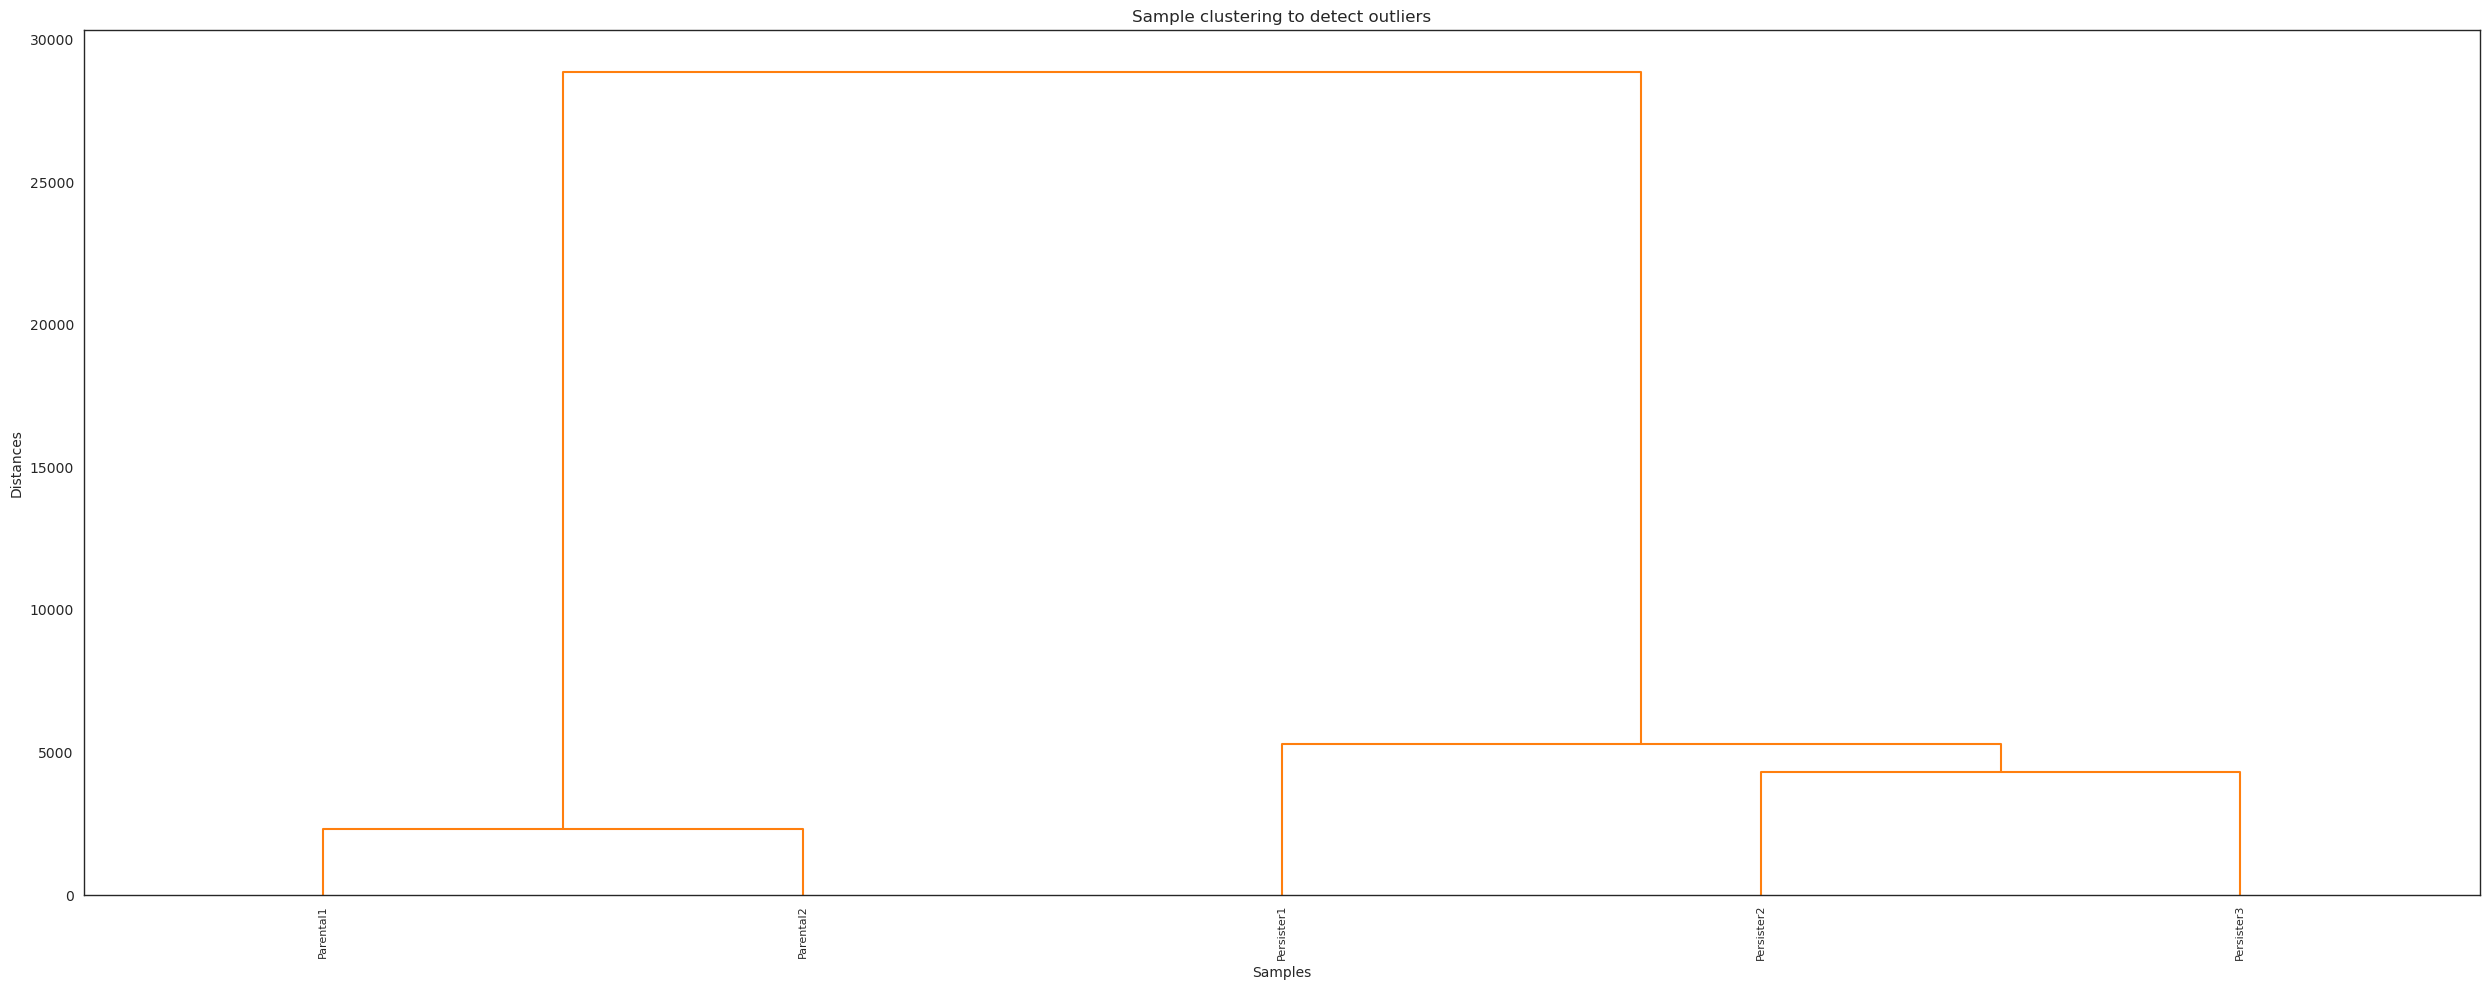

In [15]:
adata.preprocess()

Run WGCNA...
pickSoftThreshold: calculating connectivity for given powers...
will use block size  2351
    Power  SFT.R.sq     slope truncated R.sq      mean(k)    median(k)  \
0       1  0.352866  1.055182       0.176843  6746.884547  6120.940402   
1       2  0.240405  0.471039       0.239644  5427.940956  5458.358055   
2       3  0.079406  0.223838       0.224344  4645.696207  4996.006413   
3       4  0.018985  0.098426       0.279748   4108.18338  4608.999376   
4       5  0.000446  0.014506       0.325649  3707.460406  4258.785569   
5       6  0.001276 -0.022377       0.468445  3392.823582  3941.707765   
6       7  0.006091 -0.044688       0.642348  3136.761935  3657.791651   
7       8  0.020713 -0.078914       0.703442  2922.825319  3397.668353   
8       9  0.042337 -0.111087       0.716515  2740.461861  3154.583602   
9      10  0.067204  -0.13836       0.714124  2582.532978  2939.644184   
10     11  0.093561 -0.163346       0.718453  2444.003097  2749.137445   
11     13

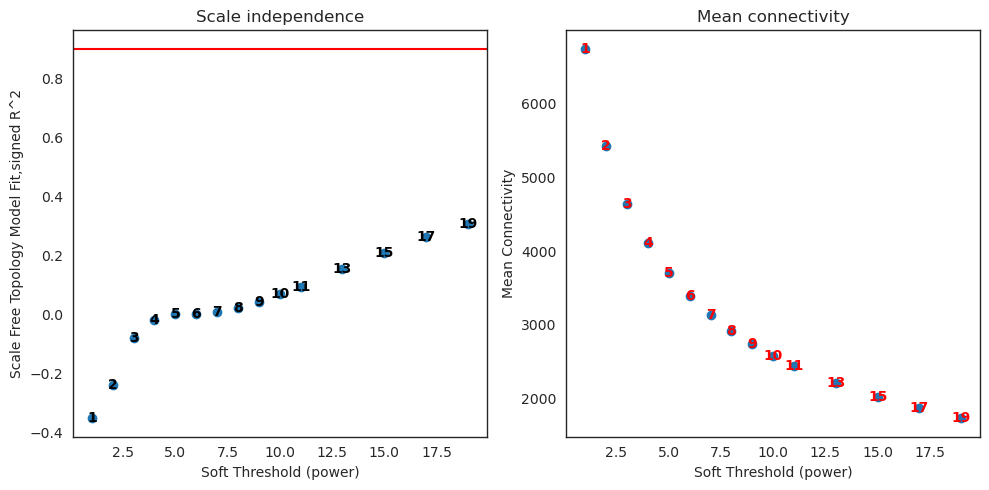

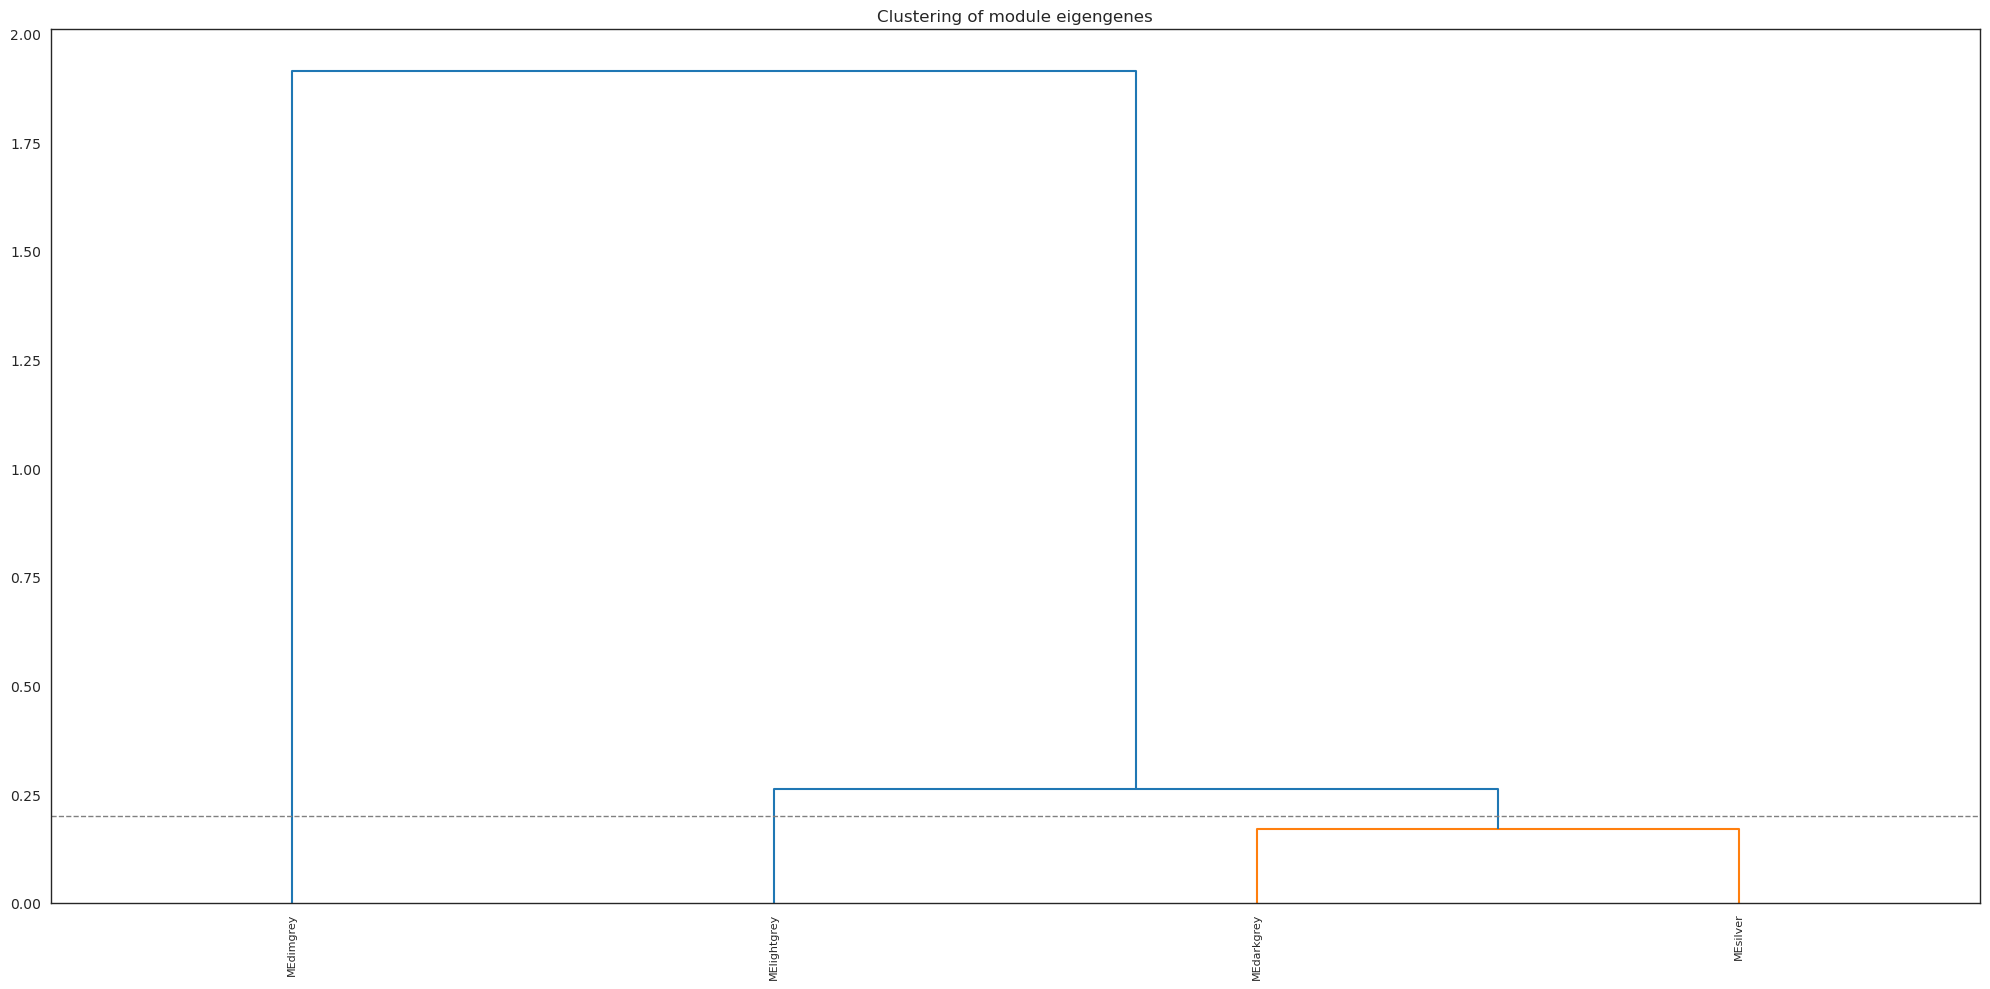

In [16]:
# Takes ~15m
adata.findModules()

In [22]:
metadata

,condition,replicate
Parental1,Parental,1
Parental2,Parental,2
Persister1,Persister,1
Persister2,Persister,2
Persister3,Persister,3


In [26]:
adata.updateSampleInfo(metadata)

In [27]:
# add color for metadata
adata.setMetadataColor(
    'condition', {'Persister': 'darkviolet', 'Parental': 'deeppink'}
)


Analysing WGCNA...
Calculating module trait relationship ...
	Done..

Adding (signed) eigengene-based connectivity (module membership) ...
	Done..

plotting module heatmap eigengene...
	Done..

plotting module barplot eigengene...
	Done..

doing Enrichr GO analysis for each module...
	gene name didn't found in gene information!
	 Go term analysis can not be done
	Done..



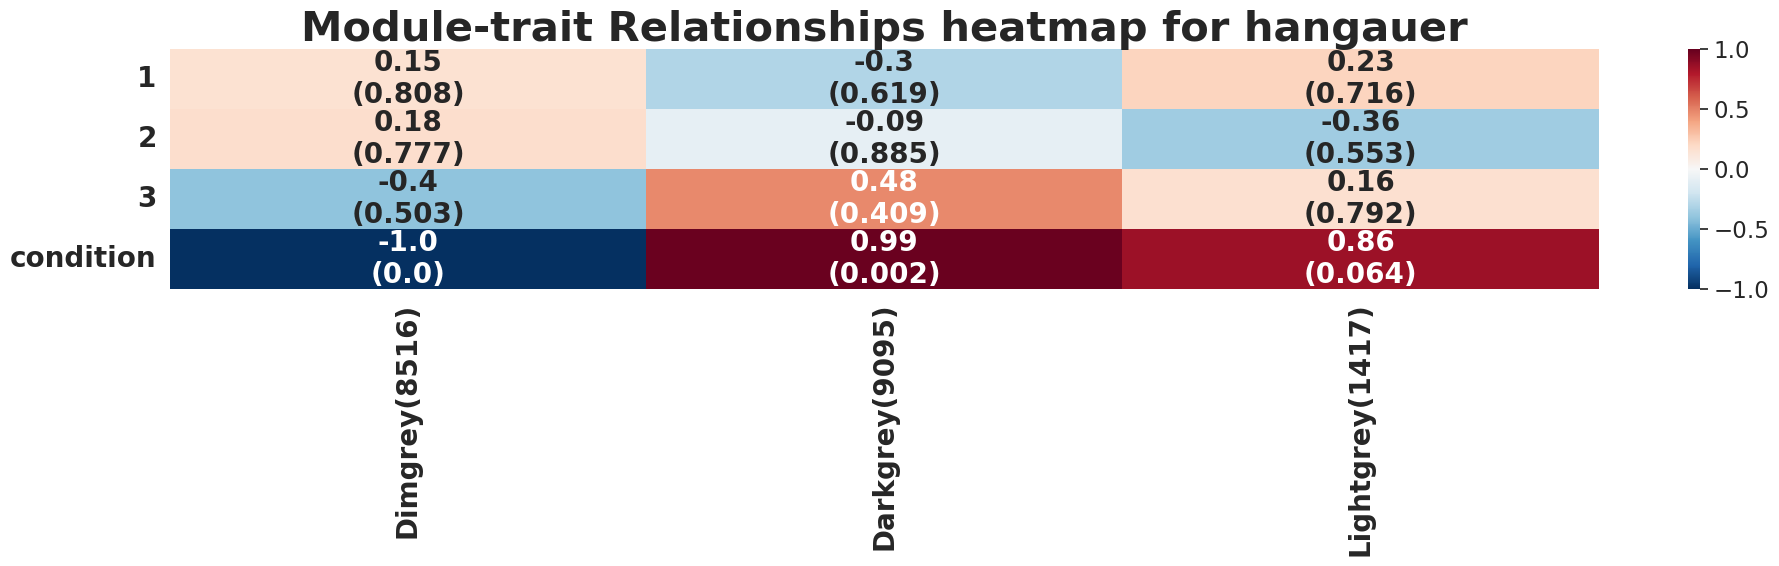

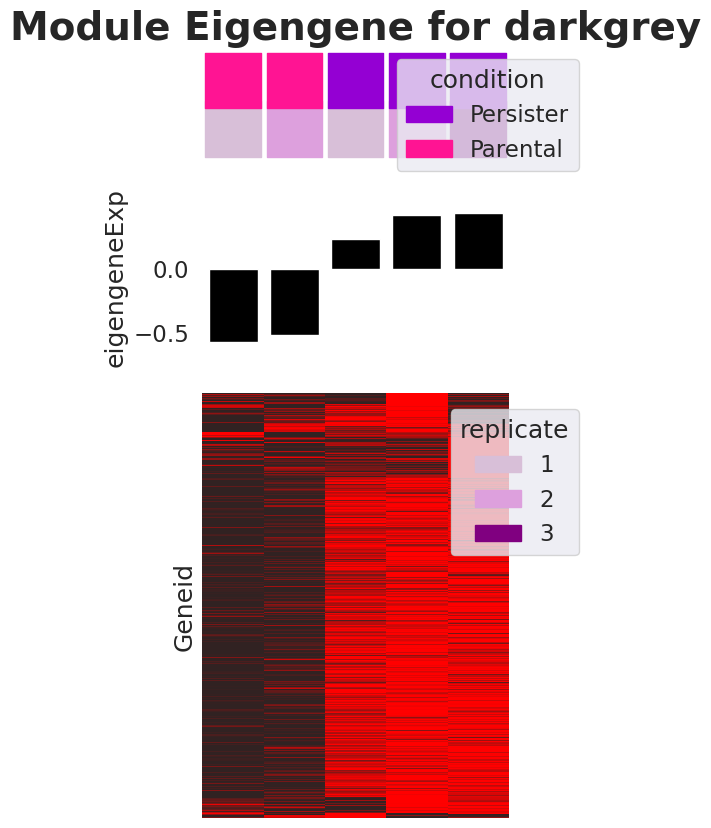

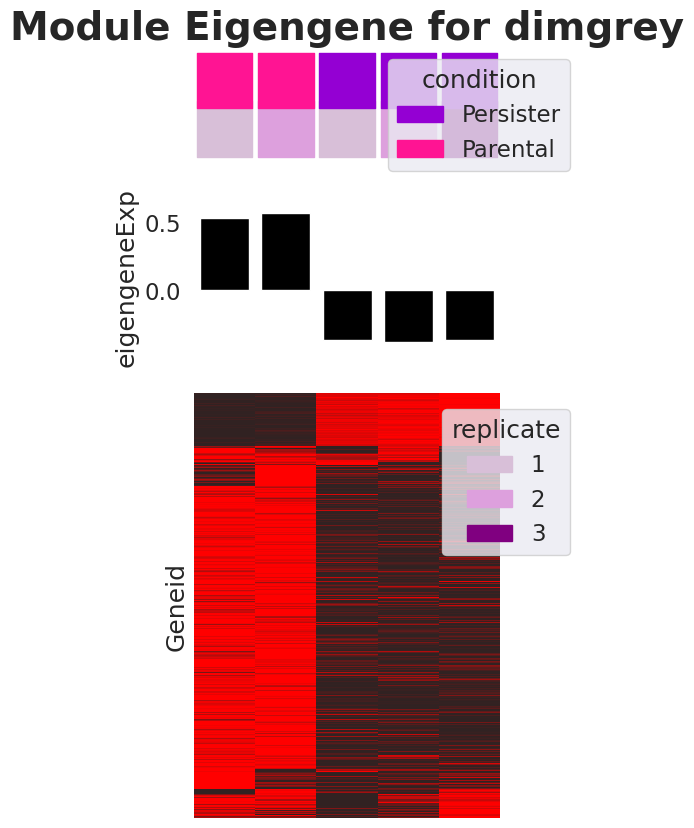

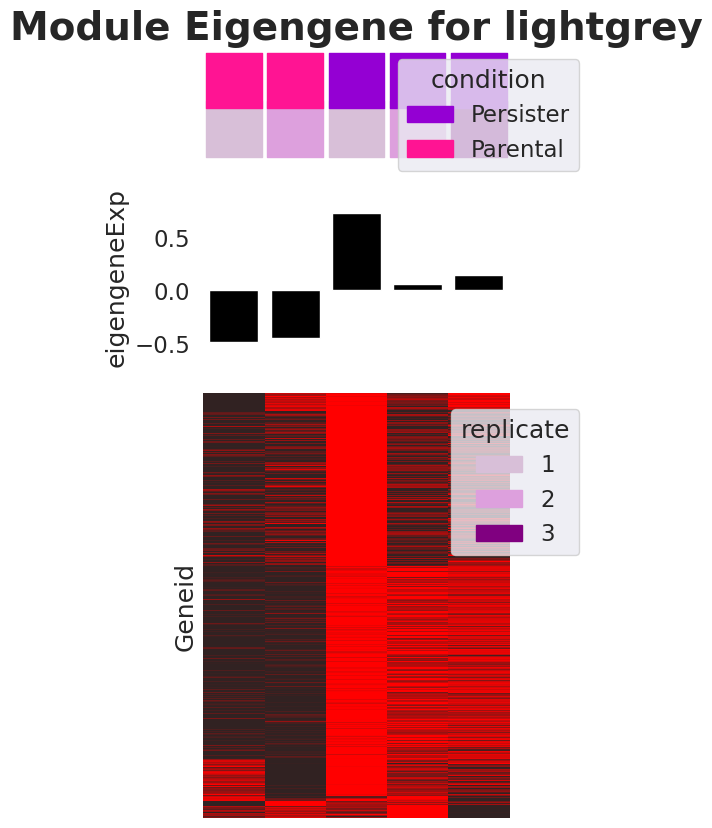

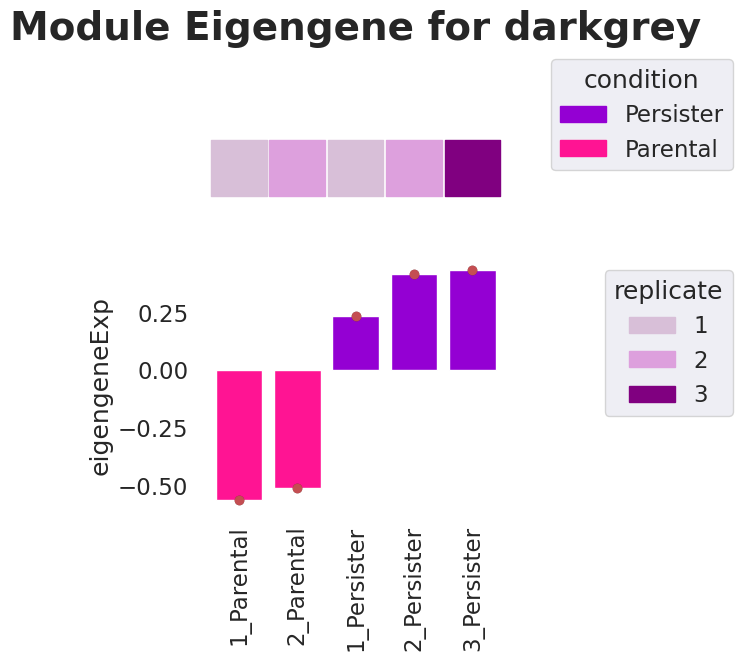

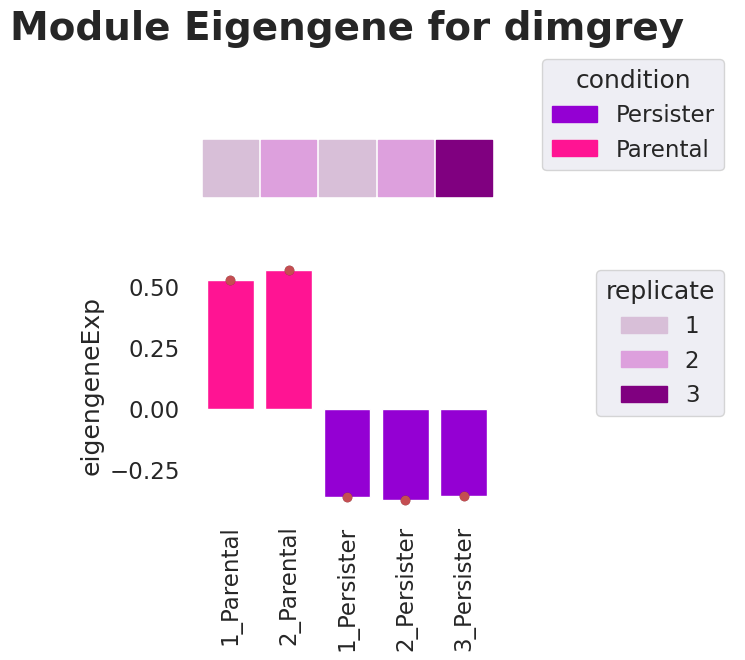

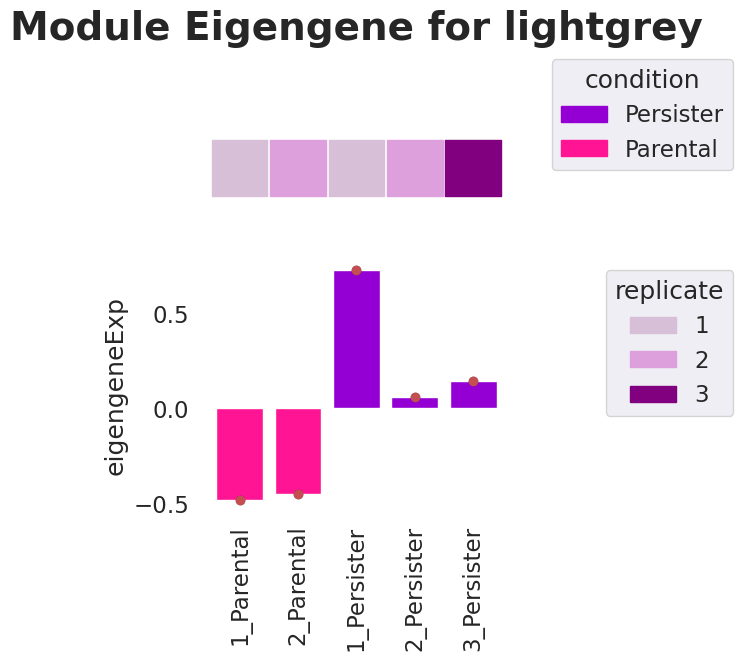

In [28]:
adata.analyseWGCNA()

In [29]:
adata.top_n_hub_genes(moduleName="lightgrey", n=10)

calculating adjacency matrix ...
	Done..



,connectivity,dynamicColors,moduleColors,moduleLabels
Geneid,,,,
ENSG00000163159.7,1103.783898,lightgrey,lightgrey,2
ENSG00000230355.1,1102.983364,lightgrey,lightgrey,2
ENSG00000259933.2,1102.738950,lightgrey,lightgrey,2
ENSG00000236867.1,1102.573092,lightgrey,lightgrey,2
ENSG00000198960.6,1102.502967,lightgrey,lightgrey,2
ENSG00000243659.1,1102.111424,lightgrey,lightgrey,2
ENSG00000248367.1,1101.300171,lightgrey,lightgrey,2
ENSG00000250174.1,1100.518978,lightgrey,lightgrey,2
ENSG00000261526.1,1099.777606,lightgrey,lightgrey,2


In [30]:
adata.saveWGCNA()

Saving WGCNA as hangauer.p
